# State-averaged MCSCF

## CASCI response

As for truncated CI, the exact state response formulas also apply to CASCI and other active space CIs. The method can thus create all excited states that arise from excitations within the active space. This can also be used as an approximation for a MCSCF response, neglecting the orbital part of the response.

Let us try it on our usual water case. We'll use an active space including the 2 pairs of O-H $\sigma$ and $\sigma^*$ (4 electrons in 4 orbitals). However, since the main excitation also involves the oxygen lone pair, we add this orbital too, for a total CAS(6,5).

First, we try the intuitive concept of first optimizing the CASSCF wavefunction for the ground state, and then applying CASCI response with the 5 states.

In [1]:
import veloxchem as vlx
import multipsi as mtp

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "INTEL".


In [2]:
# CAS(6,5) calculation of water

mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis = vlx.MolecularBasis.read(molecule, "6-31g")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
space.CAS(6,5) #3 O_2p and 2 H_1s
# CASSCF calculation
mcscf_drv=mtp.McscfDriver()
mcscf_drv.compute(molecule,basis,space)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -75.991312026     0.0e+00      3.6e-02          1   0:00:00
        2     -76.006166338    -1.5e-02      6.3e-02          1   0:00:00
        3     -76.032227092    -2.6e-02      3.2e-02          1   0:00:00
        4

                                                                                                                          
Total MCSCF time: 00:00:00


In [3]:
nstates=5

# CASCI excitation energies
cidrv=mtp.CIDriver()
cidrv.compute(molecule,basis,space,nstates)

# Transition properties
SI=mtp.InterState()
DipOsc=SI.diposc(molecule,basis,cidrv.vecs)


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        CI Iterations
        -------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm |   Time
     ----------------------------------------------------------
        1     -75.358106178     0.0e+00      4.8e-24   0:00:00
                                                                                                                          
** Convergence reached in 1 iterations
                                  

In [4]:
# Results computed in CI response
FCI_excitation_energies=[8.44992, 10.68451, 10.97654, 13.37692]
CIS_excitation_energies=[9.38059, 11.30739, 11.83172, 13.90237]
au2ev = 27.211386
print("Full CI Energies")
print(FCI_excitation_energies)
print("CIS Energies")
print(CIS_excitation_energies)
print("CASCI Energies")
print(au2ev*DipOsc['energies'])

Full CI Energies
[8.44992, 10.68451, 10.97654, 13.37692]
CIS Energies
[9.38059, 11.30739, 11.83172, 13.90237]
CASCI Energies
[18.61974291 18.73087038 26.61579239 28.51654574]


As we can see, the result is very disappointing, very far from the full CI result, and even from the CIS result. The reason for that is the orbitals. The orbitals were optimized for the ground state, and not for the excited states. Like for truncated CI, we thus have an imbalance between the description of the ground and excited states leading to (significantly) too high excitation energies. In particular, in this case, the $\sigma^*$ orbitals are optimal to describe correlation in the O-H bonds, but not for the electronic excitation.

## State-averaging

Ideally, we would want each state to have its own orbitals, which a full MCSCF response would provide. However, there is a way to improve the result without including the orbital response. The concept is to use only one orbital set, but to make these orbitals a "compromise" between the needs of the ground state and that of the excited states. The description of each state would be worse but the hope is that this error would be consistent across all states and mostly cancel out in the excitation energies.

The way to do this is to construct a "state-average" MCSCF (SA-MCSCF), that is optimize the orbitals to minimize the average energy of all states. Doing this requires only a trivial modification of the code, namely the CI part of the MCSCF includes all states (here 5) and then the MCSCF energy is replaced by the average energy of all states and the CI densities are replaced by the average density of all states.

Let's see it in practice:

In [5]:
# CASSCF calculation
mcscf_drv.compute(molecule,basis,space,nstates) #5 states included already in the MCSCF.

# Transition properties
DipOsc=SI.diposc(molecule,basis,mcscf_drv.CIVecs)


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -75.358106178     0.0e+00      3.2e-01          1   0:00:00
        2     -75.521955636    -1.6e-01      2.9e-01          1   0:00:00
        3     -75.654098795    -1.3e-01      2.0e-01          1   0:00:00
        4

                                                                                                                          
Total MCSCF time: 00:00:00
                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.55788         1.182610e-02    2.629897e-02
     1       4       10.32868         1.101141e-01    1.302112e-01
     1       5       12.56324         1.491877e-01    1.439100e-01


In [6]:
print("Full CI Energies")
print(FCI_excitation_energies)
print("CIS Energies")
print(CIS_excitation_energies)
print("SA-CASSCF Energies")
print(au2ev*DipOsc['energies'])

Full CI Energies
[8.44992, 10.68451, 10.97654, 13.37692]
CIS Energies
[9.38059, 11.30739, 11.83172, 13.90237]
SA-CASSCF Energies
[ 7.55787583  9.83566209 10.32868402 12.56323891]


The result is now significantly closer to the converged full CI result. In this particular case, the result is not better than CIS, but of course, one the main motivation to use MCSCF is for systems with strong correlation, which was not the case here.

This method is of course not without issues. In particular, unlike standard responses calculation, the introduction of state-averaging means that the excitation energies depend on the total number of states, since the state-averaged orbitals depend on all states. In particular, we can expect the results to deteriorate with increasing number of states as the orbitals begin to compromise many states of widely different natures:

In [7]:
first_exc_energy=[]
for nstates in range(2,6):
    
    # CASSCF calculation
    mcscf_drv.compute(molecule,basis,space,nstates) #5 states included already in the MCSCF.

    # Transition properties
    DipOsc=SI.diposc(molecule,basis,mcscf_drv.CIVecs)
    
    first_exc_energy.append(au2ev*DipOsc['energies'][0])


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -75.843270715     0.0e+00      1.1e-01          1   0:00:00
        2     -75.858829274    -1.6e-02      6.9e-02          1   0:00:00
        3     -75.864455907    -5.6e-03      2.8e-02          1   0:00:00
        4

                                                                                                                          
Total MCSCF time: 00:00:00
                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        8.08803         8.153140e-03    3.791438e-02

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                      

                                                                                                                          
Total MCSCF time: 00:00:00
                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.95275         8.899154e-03    4.003592e-02
     1       3       15.27448         3.502949e-01    3.169114e-01

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                   

                                                                                                                          
Total MCSCF time: 00:00:00
                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.85494         7.812110e-03    4.149883e-02
     1       4       14.92669         4.583994e-01    3.096527e-01

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                   

                                                                                                                          
Total MCSCF time: 00:00:00
                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.55790         1.182597e-02    2.629915e-02
     1       4       10.32870         1.101138e-01    1.302110e-01
     1       5       12.56326         1.491866e-01    1.439092e-01


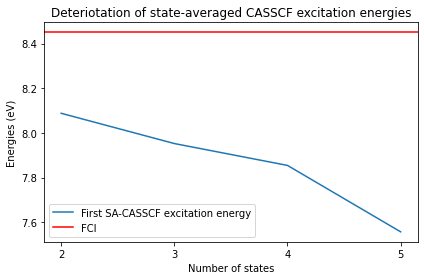

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
x = np.array(range(2,6))
plt.plot(x,np.array(first_exc_energy), label='First SA-CASSCF excitation energy')
plt.title('Deteriotation of state-averaged CASSCF excitation energies')
plt.ylabel("Energies (eV)")
plt.xlabel("Number of states")
plt.axhline(y=FCI_excitation_energies[0],label ='FCI',color='red')
plt.xticks(x)
plt.legend()
plt.tight_layout(); plt.show()

While for 2 states, the first excitation energy was relatively close to the fullCI, it degrades significantly as more states are added, with a difference of more than 0.5 eV going from 2 to 5 states. Adding dynamical correlation on-top of the CASSCF typically reduces this error, but it is still an undesirable behaviour.

Still, because of its simplicity and its reasonable accuracy, SA-MCSCF is one of the most frequently used technique to compute properties at the MCSCF level.